In [14]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import tarfile
import random
from tensorflow import keras

from os import listdir
from datetime import datetime
# from keras.preprocessing.image import ImageDataGenerator

In [3]:
tarf = tarfile.open('./fer2013.tar.gz')
tarf.extractall()

In [15]:
emotion_strings = [
    'Angry'      # 0
    , 'Disgust'  # 1
    , 'Fear'     # 2
    , 'Happy'    # 3
    , 'Sad'      # 4
    , 'Surprise' # 5
    , 'Neutral'  # 6
]

def emo_to_string(emotion):
    return emotion_strings[np.argmax(emotion)]

for i in range(7):
    arr = np.zeros(shape=(7))
    arr[i] = 1
    print(emo_to_string(arr))

Angry
Disgust
Fear
Happy
Sad
Surprise
Neutral


e:\python\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


(35887, 48, 48, 1)


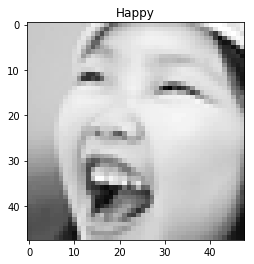

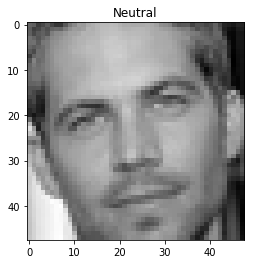

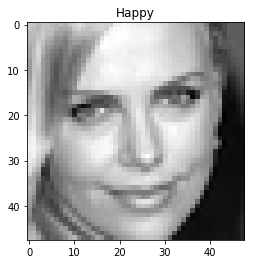

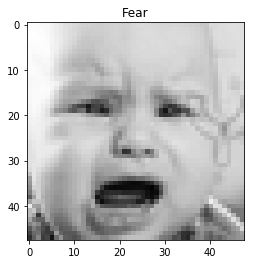

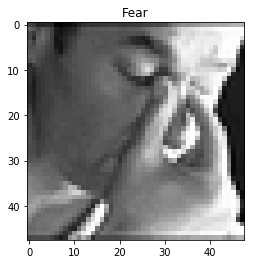

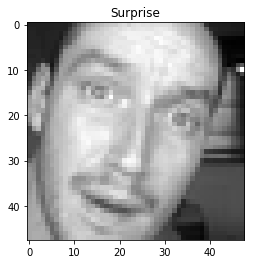

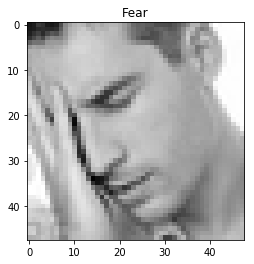

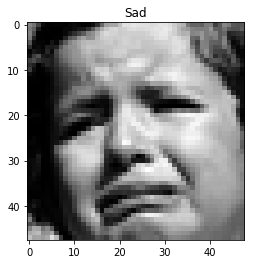

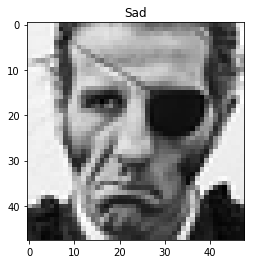

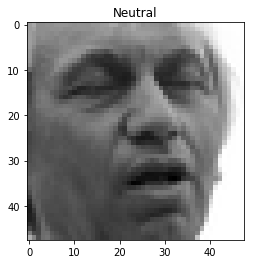

In [16]:
data = pd.read_csv('./fer2013/fer2013.csv')
width = 48
height = 48

# Covert pixels column to a list
pixels = data['pixels'].tolist()
emotions = pd.get_dummies(data['emotion']).as_matrix()

faces = []

for pixel_sequence in pixels:
    # Split the string by space character as a list
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    
    # convert to numpy array
    face = np.asarray(face).reshape(width, height)
    
    faces.append(face.astype('float32'))
    
faces = np.asarray(faces)
# normalize data 
# faces /= 255.0
# center data
faces = faces - np.mean(faces)
faces = np.expand_dims(faces, -1)
print(faces.shape)

r = np.random.randint(len(faces), size=10)
for i in r:
    img = faces[i,:,:,0];
    plt.imshow(img, cmap='gray')
    plt.title(emo_to_string(emotions[i]))
    plt.show()

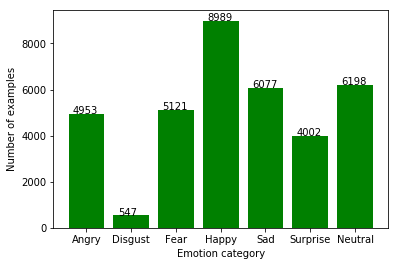

In [6]:
# obtain counts for each of the categories
counts = collections.Counter([np.argmax(row) for row in emotions])

emo_ids = list(counts.keys())
emo_counts = list(list(counts.values()))
bars = plt.bar(emo_ids, emo_counts, color='g')
plt.xticks(emo_ids, [emotion_strings[i] for i in emo_ids])
plt.xlabel("Emotion category")
plt.ylabel("Number of examples")
for i, bar in enumerate(bars):
    y = bar.get_height()
    plt.text(bar.get_x() + 0.1, y + 1, emo_counts[i])
plt.show()

In [31]:
train_count = 28709
val_count = 3589
test_count = 3589
num_channels = 1
num_classes = 7

perm = np.random.permutation(faces.shape[0])
train_dataset = faces[perm[:train_count]]
train_labels = emotions[perm[:train_count]]
valid_dataset = faces[perm[train_count:train_count+val_count]]
valid_labels = emotions[perm[train_count:train_count+val_count]]
test_dataset = faces[perm[train_count+val_count:]]
test_labels = emotions[perm[train_count+val_count:]]

datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=45,
                                                      zoom_range=[0.8, 1.2],
                                                      horizontal_flip=True,
                                                      width_shift_range=3.0)
datagen.fit(train_dataset)

# Change width and height to the new values
width = 42
height = 42

def resize(set):
    return np.asarray([np.resize(example, new_shape=(width, height, 1)) for example in train_dataset])


print('Train: %s %s' % (train_dataset.shape, train_labels.shape))
print('Validation: %s %s' % (valid_dataset.shape, valid_labels.shape))
print('Test: %s %s' % (test_dataset.shape, test_labels.shape))

Train: (28709, 48, 48, 1) (28709, 7)
Validation: (3589, 48, 48, 1) (3589, 7)
Test: (3589, 48, 48, 1) (3589, 7)


In [30]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2, strides=1):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], 
                          strides=[1, strides, strides, 1], padding='SAME')

def averagepool2d(x, k=2, strides=1):
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], 
                          strides=[1, strides, strides, 1], padding='SAME')
# r1 -> filter for reduce of 3x3
# r2 -> filter for reduce of 5x5
# w1 -> 1x1 filter
# w3 -> 3x3 filter
# w5 -> 5x5 filter
# wp -> 1x1 pool proj filters
# b -> bias
def inception(x, weights, bias):
    # 1x1
    one_by_one = tf.nn.conv2d(x, weights['w1'], strides=[1,1,1,1], padding='SAME')
    
    # 3x3
    three_by_three_red = tf.nn.conv2d(x, weights['r1'], 
                                      strides=[1,1,1,1], padding='SAME')
    three_by_three = tf.nn.conv2d(three_by_three_red, weights['w3'],
                                  strides=[1,1,1,1], padding='SAME')
    
    # 5x5
    five_by_five_red = tf.nn.conv2d(x, weights['r2'], 
                                    strides=[1,1,1,1], padding='SAME')
    five_by_five = tf.nn.conv2d(five_by_five_red, weights['w5'],
                                strides=[1,1,1,1], padding='SAME')
    
    # Projection pooling
    max_pool = tf.nn.max_pool(x, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')    
    pooling = tf.nn.conv2d(max_pool, weights['wp'],
                           strides=[1,1,1,1], padding='SAME')
    
    x = tf.concat([one_by_one, three_by_three, five_by_five, pooling], axis=3)
    x = tf.nn.bias_add(x, bias)
    
    return tf.nn.relu(x)
    

In [49]:
def l2_svm(logits, labels):
    return tf.reduce_sum(tf.square(tf.maximum(tf.zeros([batch_size,num_classes]), 
                                    1 - logits*labels)))

Implementation of the solution proposed in https://arxiv.org/pdf/1511.04110.pdf
Architecture consists of:


*  2 traditional CNN modules
*  2 Inception-style modules



In [64]:
def svm_net(x, weights, biases, keep_prob=0.5, train=True):
    conv1 = conv2d(x, weights['conv1'], biases['conv1'], strides=1) # 42 x 42 x 32
    conv1 = maxpool2d(conv1, strides=2) # 21 x 21 x 32
    
    conv2 = conv2d(conv1, weights['conv2'], biases['conv2'], strides=1) # 21 x 21 x 32
    conv2 = averagepool2d(conv2, strides=2) # 11 x 11 x 32
    
    conv3 = conv2d(conv2, weights['conv3'], biases['conv3'], strides=1) # 11 x 11 x 64 
    conv3 = averagepool2d(conv3, strides=2)
    
    fc1 = tf.reshape(conv3, [-1, weights['fc1'].get_shape().as_list()[0]])
    fc1 = tf.nn.relu(tf.matmul(fc1, weights['fc1']) + biases['fc1'])
    if train:
        fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)
    
    out = tf.matmul(fc1, weights['out']) + biases['out']
    return tf.nn.relu(out)

In [71]:
graph = tf.Graph()
keep_prob = 0.8
svm_C = 1

with graph.as_default(), tf.device('/gpu:0'):
    weights = {
        'conv1': tf.get_variable('conv1', shape=(5,5,1,32), 
                           initializer=tf.contrib.layers.xavier_initializer()),
        'conv2': tf.get_variable('conv2', shape=(4,4,32,32), 
                           initializer=tf.contrib.layers.xavier_initializer()),
        'conv3': tf.get_variable('conv3', shape=(5,5,32,64),
                           initializer=tf.contrib.layers.xavier_initializer()),
        'fc1': tf.get_variable('fc1', shape=(2304,3072),
                           initializer=tf.contrib.layers.xavier_initializer()),
        'out': tf.get_variable('out', shape=(3072,7), 
                           initializer=tf.contrib.layers.xavier_initializer())
    }
    biases = {
        'conv1': tf.get_variable('conv1_bias', shape=(32), 
                        initializer=tf.zeros_initializer()),
        'conv2': tf.get_variable('conv2_bias', shape=(32), 
                        initializer=tf.zeros_initializer()),
        'conv3': tf.get_variable('conv3_bias', shape=(64),
                        initializer=tf.zeros_initializer()),
        'fc1': tf.get_variable('fc1_bias', shape=(3072), 
                        initializer=tf.zeros_initializer()),
        'out': tf.get_variable('out_bias', shape=(7), 
                        initializer=tf.zeros_initializer())
    }
    
    tf_train_dataset = tf.placeholder(tf.float32, [None, width, height, num_channels])
    tf_train_labels = tf.placeholder(tf.float32, [None, num_classes])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    logits = svm_net(tf_train_dataset, weights, biases, keep_prob)
    svm_loss = svm_C * l2_svm(logits, tf_train_labels)
    l2_reg = tf.reduce_sum(tf.square(weights['out']))/2.0
    loss = l2_reg + svm_loss
    tf_loss_summary = tf.summary.scalar('loss', loss)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
    
    train_accuracy = accuracy(logits, train_labels)
#     valid_prediction = tf.nn.softmax(neural_net(tf_valid_dataset, weights, biases))
#     test_prediction = tf.nn.softmax(neural_net(tf_test_dataset, weights, biases))
    valid_prediction = svm_net(tf_valid_dataset, weights, biases, train=False)
    test_prediction = svm_net(tf_test_dataset, weights, biases, train=False)
    valid_accuracy = accuracy(valid_prediction, valid_labels)
    test_accuracy = accuracy(test_prediction, test_labels)
#     tf_valid_loss_sum = tf.summary.scalar('validation_loss', valid_loss)
#     tf_valid_acc_sum = tf.summary.scalar('validation_accuracy', valid_accuracy)
#     valid_summary = tf.summary.merge([tf_valid_loss_sum, tf_valid_acc_sum])

ValueError: Dimensions must be equal, but are 28709 and 3589 for 'Equal_1' (op: 'Equal') with input shapes: [28709], [3589].

In [66]:
def accuracy(predictions, labels):
    equality = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    return tf.reduce_mean(tf.cast(equality, tf.float32))

In [72]:
batch_size = 10
num_steps = 100000
step = 0
writer_val = tf.summary.FileWriter("logs/scalars/train/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

valid_dataset = resize(valid_dataset)
test_dataset = resize(test_dataset)

with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    tf.global_variables_initializer().run()
    for batch, labels in datagen.flow(train_dataset, train_labels, shuffle=False, batch_size=batch_size):
    #         start = (step*batch_size)%train_count
    #         end = (start+batch_size)%train_count
    #         batch = train_dataset[start:end]
    #         labels = train_labels[start:end]
        batch = resize(batch)
        _, l, pred, summary, acc = sess.run([optimizer, loss, train_prediction, 
                                             train_accuracy],
                             feed_dict={tf_train_dataset: batch,
                                       tf_train_labels: labels})
        train_writer.add_summary(summary, step)
        if(step%100 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Validation accuracy %f' % (valid_accuracy.eval()))
            print('Minibatch accuracy %f' % (acc))
    #             val_summary = sess.run(valid_summary)
    #             valid_writer.add_summary(val_summary, step)
        if(step >= num_steps):
            break
        step = step + 1
    print("Test accuracy: %f" % (test_accuracy.eval()))

ValueError: Fetch argument <tf.Tensor 'Relu_4:0' shape=(?, 7) dtype=float32> cannot be interpreted as a Tensor. (Tensor Tensor("Relu_4:0", shape=(?, 7), dtype=float32, device=/device:GPU:0) is not an element of this graph.)

In [ ]:
%tensorboard --logdir {"./logs/scalars"}

In [20]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15364257514675894714
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9804866162357347889
physical_device_desc: "device: XLA_CPU device"
]
